*New and tidied up notebook for faster and easier testing of the models*

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
from collections import OrderedDict
import os
import sys
import inspect
import json
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import dask.dataframe as dd
import pandas as pd
from argparse import Namespace
from tqdm.notebook import tqdm

from log_analyzer.train_loop import init_from_config_files, train_model
import log_analyzer.data.data_loader as data_utils

print(cuda := torch.cuda.is_available())
# torch.manual_seed(1)

True


# Parameter setting

In [2]:
def set_args(bidir, model_type, token_level):
    """Prepares a Namespace of the same format and fields as created by argparse when parsing user input from the commandline."""
    # Common args (defaults, can be changed)
    args = {}

    args['bidirectional'] = bidir
    args['model_type'] = model_type
    args['trainer_config_file'] = '../config/config_trainer.json'

    if token_level == 'word':
        args['data_folder']= '../data/data_examples/word_day_split'
        args['data_config_file']= '../config/lanl_word_config_data.json'
        if model_type == 'lstm':
            args['model_config_file'] = '../config/lanl_word_config_model.json'
        elif model_type == 'tiered-lstm':
            args['model_config_file'] = '../config/lanl_word_config_model_tiered.json'
    elif token_level == 'char':
        args['data_folder'] = '../data/data_examples/char_day_split'
        args['data_config_file']= '../config/lanl_char_config_data.json'
        if model_type == 'lstm':
            args['model_config_file'] = '../config/lanl_char_config_model.json'
        elif model_type == 'tiered-lstm':
            args['model_config_file'] = '../config/lanl_char_config_model_tiered.json'
    else:
        print("Error: unexpected token_level, args not prepared.")
        return
    
    # Return the prepared args
    return args

In [3]:
# Note: hyperparameters, such as learning rate and patience, are read in from the config file.
#       (Change them there if you want to try other values)

# Specify the configuration of the model
# All combinations currently supported except bidir + tiered
bidir = True
model_type = 'lstm' # 'lstm', 'tiered-lstm', 'transformer'
token_level = 'word' # 'word' or 'char'

# Get the args for the model version defined above
args = set_args(bidir, model_type, token_level)


# Train model
### (One epoch, full dataset)


In [4]:
%%time
# Create and train the model
trainer, train_loader, test_loader = init_from_config_files(**args)
train_losses, test_losses = train_model(trainer, train_loader, test_loader, store_eval_data=True)

0it [00:00, ?it/s]

870560072362423
EarlyStopping counter: 83940 out of 500000. Best loss: 0.0010870560072362423
EarlyStopping counter: 83950 out of 500000. Best loss: 0.0010870560072362423
EarlyStopping counter: 83960 out of 500000. Best loss: 0.0010870560072362423
EarlyStopping counter: 83970 out of 500000. Best loss: 0.0010870560072362423
EarlyStopping counter: 83980 out of 500000. Best loss: 0.0010870560072362423
EarlyStopping counter: 83990 out of 500000. Best loss: 0.0010870560072362423
EarlyStopping counter: 84000 out of 500000. Best loss: 0.0010870560072362423
EarlyStopping counter: 84010 out of 500000. Best loss: 0.0010870560072362423
EarlyStopping counter: 84020 out of 500000. Best loss: 0.0010870560072362423
EarlyStopping counter: 84030 out of 500000. Best loss: 0.0010870560072362423
EarlyStopping counter: 84040 out of 500000. Best loss: 0.0010870560072362423
EarlyStopping counter: 84050 out of 500000. Best loss: 0.0010870560072362423
EarlyStopping counter: 84060 out of 500000. Best loss: 0.001

0it [00:00, ?it/s]

CPU times: user 1h 2min 54s, sys: 17min 31s, total: 1h 20min 25s
Wall time: 1h 18min 27s


Text(0.5, 1.0, 'Training losses - Bidirectional lstm, word token.')

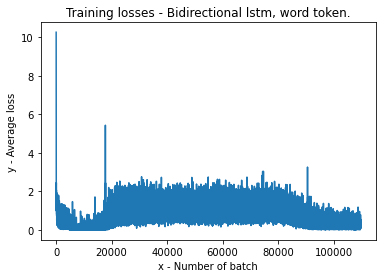

In [5]:
# Plot the train loss over time
plt.plot(train_losses)
#plt.ylim((0, 5))
# naming the x axis
plt.xlabel('x - Number of batch')
# naming the y axis
plt.ylabel('y - Average loss')
plt.title(f"Training losses - {'Bidirectional' if bidir else 'Forward'} {model_type}, {token_level} token.")

In [6]:
trainer.evaluator.prepare_evaluation_data()
print(f"Final test loss (avg): {np.mean(test_losses)}")
print(f"Token accuracy:        {trainer.evaluator.get_token_accuracy()}")
print(f"Token perplexity:      {trainer.evaluator.get_token_perplexity()}")

Final test loss (avg): 0.8207504893801085
Token accuracy:        0.9329626646466808
Token perplexity:      2.2722108325434136


  0%|          | 0/288 [00:00<?, ?it/s]

CPU times: user 818 ms, sys: 698 ms, total: 1.52 s
Wall time: 1.51 s


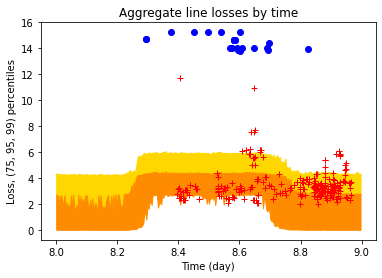

In [7]:
%%time
trainer.evaluator.plot_line_loss_percentiles(percentiles=[75,95,99], smoothing=300, ylim=(-1,-1), outliers=1, legend=False)

0.8857825984168705
CPU times: user 21.5 s, sys: 315 ms, total: 21.8 s
Wall time: 21.8 s


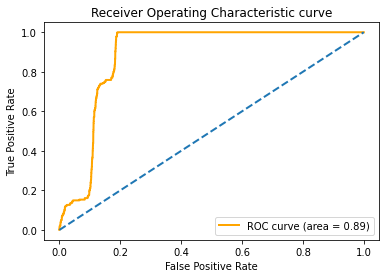

In [8]:
%%time
print(trainer.evaluator.plot_roc_curve())

In [9]:
%%time
# Normalize anomaly scores
trainer.evaluator.normalize_losses()

  0%|          | 0/9328 [00:00<?, ?it/s]

CPU times: user 1min 38s, sys: 23.7 ms, total: 1min 38s
Wall time: 1min 38s


  0%|          | 0/288 [00:00<?, ?it/s]

CPU times: user 941 ms, sys: 196 ms, total: 1.14 s
Wall time: 1.14 s


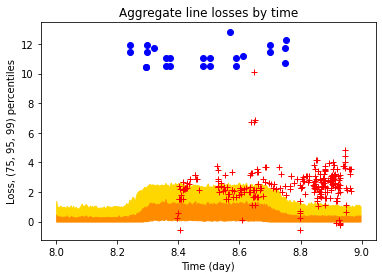

In [10]:
%%time
trainer.evaluator.plot_line_loss_percentiles(percentiles=[75,95,99], smoothing=300, ylim=(-1,-1), outliers=1, legend=False)

0.9690996896995837
CPU times: user 21.8 s, sys: 351 ms, total: 22.2 s
Wall time: 22.1 s


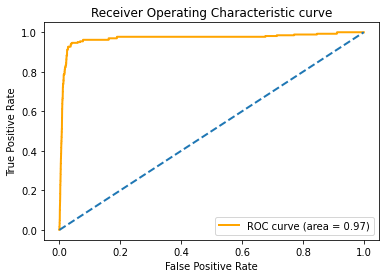

In [11]:
%%time
print(trainer.evaluator.plot_roc_curve())

# Spot check model performance

In [ ]:
args.batch_size = 1
_, test_loader = data_utils.load_data(train_days, test_days, args, sentence_length)

# Grab the first batch from the test_loader
for batch in test_loader:
    break

loss, output = trainer.eval_step(batch)
# The input/output of tiered models have an additional dimension, which we have to squeeze out
preds = torch.argmax(output[0], dim=-1)[0] if args.tiered else torch.argmax(output[0], dim=-1)
gt = batch['t'][0][0][:len(preds)] if args.tiered else batch['t'][0][:len(preds)]

# Get the ground truth ('t') of the first line in the batch extracted above
print(f'Ground truth: {gt}')
print(f'Model prediction: {preds}')
print(f'Loss: {loss}')


# Overfit model

### (100+ epochs, 1-10 log lines, train=test set)

### (By overfitting LSTM model on a small dataset, let me check whether the model has ability to learn the relation between input and output)


In [ ]:
%%time
# Set batch_size to 1 so we train on a single line only
args.batch_size = 1
train_loader, _ = data_utils.load_data(train_days, test_days, args, sentence_length)

trainer = create_model(args)

for batch in train_loader:
    break

# Disable verbose of the early_stopping object to avoid large amounts of output
trainer.early_stopping.verbose = False
train_losses = []
epochs = 500
# tqdm provides a nice and minimal progress bar + time estimate for the loop
# If tqdm is not installed, simply comment the line out and use the alternatives below instead
#for i in range(epochs):
#    if i % 250 == 0:
#        print('Epoch: {i}')
for i in tqdm(range(epochs)):
    loss, _ = trainer.train_step(batch) # We ignore the early_stopping flag
    train_losses.append(loss.item())

trainer.early_stopping.verbose = True

In [ ]:
# Plot the train loss over time
plt.plot(train_losses)

# naming the x axis
plt.xlabel('x - Number of epoch')
# naming the y axis
plt.ylabel('y - Average loss')


In [ ]:
loss, output = trainer.eval_step(batch)
# The input/output of tiered models have an additional dimension, which we have to squeeze out
preds = torch.argmax(output[0], dim=-1)[0] if args.tiered else torch.argmax(output[0], dim=-1)
gt = batch['t'][0][0][:len(preds)] if args.tiered else batch['t'][0][:len(preds)]

# Get the ground truth ('t') of the first line in the batch extracted above
print(f'Ground truth: {gt}')
print(f'Model prediction: {preds}')
print(f'Loss: {loss}')